# This makes sure that we're taking the top 5 and bottom 5 random sampled events correctly.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import pandas as pd
import numpy as np
import sys
pd.set_option('precision',15)
from maps.density import normalization_functions as norm
from maps.plotter import Plotter
from maps.density import LineObject
from maps.density import intervals
from tqdm import tnrange, tqdm_notebook

maps/plotter/Plotter.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/bay001/anaconda2/envs/brian/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/bay001/anaconda2/envs/brian/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/ipykernel/kernelapp.py"

In [2]:
new_dir = '/projects/ps-yeolab3/bay001/maps/current/se'
old_dir = '/projects/ps-yeolab3/bay001/maps/archived/se_nr/9-14-2018/'

In [3]:
RBP = '384_01_GTF2F1.merged.r2.4'
new = glob.glob(os.path.join(new_dir, RBP + '*means.txt'))
new

['/projects/ps-yeolab3/bay001/maps/current/se/384_01_GTF2F1.merged.r2.4.GTF2F1-BGHLV14-HepG2.set14-excluded-upon-knockdown.means.txt',
 '/projects/ps-yeolab3/bay001/maps/current/se/384_01_GTF2F1.merged.r2.4.GTF2F1-BGHLV14-HepG2.set14-included-upon-knockdown.means.txt',
 '/projects/ps-yeolab3/bay001/maps/current/se/384_01_GTF2F1.merged.r2.4.HepG2_constitutive_exons.means.txt',
 '/projects/ps-yeolab3/bay001/maps/current/se/384_01_GTF2F1.merged.r2.4.HepG2_native_cassette_exons_all.means.txt',
 '/projects/ps-yeolab3/bay001/maps/current/se/384_01_GTF2F1.merged.r2.4.HepG2_natively_included_cassette_exons.means.txt',
 '/projects/ps-yeolab3/bay001/maps/current/se/384_01_GTF2F1.merged.r2.4.HepG2_natively_excluded_cassette_exons.means.txt',
 '/projects/ps-yeolab3/bay001/maps/current/se/384_01_GTF2F1.merged.r2.4.HepG2_native_cassette_exons_avg.means.txt']

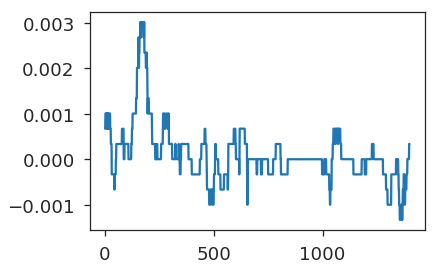

In [4]:
df = pd.read_table(new[0], names=['means'])
plt.plot(df)

In [5]:
def create_density_line(df, color, label, min_event_threshold=100):
    """ Users LineOject() to create a LineObject for each event matrix. """
    return LineObject.DensityLine(
        event_matrix=df, 
        annotation_src_file=label, 
        conf=0.95, 
        color=color, 
        min_event_threshold=min_event_threshold, 
        num_events=[df.shape[0]]*df.shape[1], # list of event numbers per position (doesn't really matter to us)
        label=label
    )
def read_matrix(fn):
    """ Reads a normalized matrix file. Returns dataframe """
    return pd.read_table(
        fn,
        sep=',',
        index_col=0
    )

In [6]:

density_inc = read_matrix(
    glob.glob(os.path.join(
        new_dir, 
        '{}.*-included-upon-knockdown.normed_matrix.txt'.format(RBP)
    ))[0]
)
density_exc = read_matrix(
    glob.glob(os.path.join(
        new_dir, 
        '{}.*-excluded-upon-knockdown.normed_matrix.txt'.format(RBP)
    ))[0]
)
density_bg = read_matrix(
    glob.glob(os.path.join(
        new_dir, 
        '{}.*native_cassette_exons_all.normed_matrix.txt'.format(RBP)
    ))[0]
)

In [7]:
excluded = create_density_line(
    df=density_exc,
    color='blue',
    label='excluded'
)
bg = create_density_line(
    df=density_bg,
    color='black',
    label='excluded'
)

[<maps.density.LineObject.DensityLine instance at 0x2aaf4e3d74d0>]


<maps.plotter.Plotter._SEPlotter instance at 0x2aaf6416fb00>

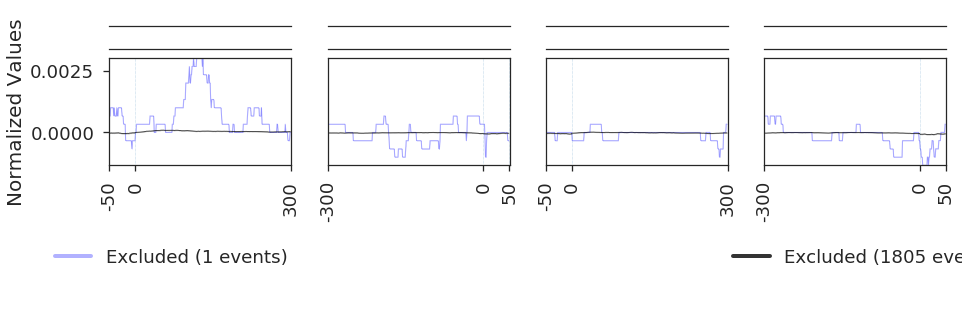

In [8]:
Plotter.plot_se(lines=[excluded, bg], output_filename=None, map_type=None)

In [9]:
# test random generated tsv
rand_incl = pd.read_table(
    glob.glob(os.path.join(
        new_dir, 
        '{}.*included*randsample.tsv'.format(RBP)
    ))[0],
    index_col=0
)
rand_excl = pd.read_table(
    glob.glob(os.path.join(
        new_dir, 
        '{}.*excluded*randsample.tsv'.format(RBP)
    ))[0],
    index_col=0
)

In [10]:
def median_bottom_top_values_from_dataframe(df, bottom_percent=0.5, top_percent=0.5):
    """
    This takes a dataframe and computes the medians of the bottom and top % for each
    column. This helps with the "permutation" background significance calculations.

    Parameters
    ----------
    df
    bottom_percent: float
        bottom percent to take median of
        (taking the median of the bottom 25% would be bottom_percent=25)
    top_percent: float
        top percent to take median of
        (taking the median of the top 25% would be top_percent=25)

    Returns
    -------
    bottom_values : list
    top_values : list
    """
    bottom_values = []
    top_values = []
    for key, value in df.iteritems():
        # get true percentage
        bottom_actual_percent = bottom_percent * 0.01
        top_actual_percent = top_percent * 0.01
        # foreach column, drop nans and get the number of starting events, sorted.
        single_col = df[key].dropna()
        single_col = single_col.sort_values()
        nums = len(single_col)
        # collect top (top subset) 0.5% and bottom 0.5% of values
        bottom_subset = int(bottom_actual_percent * nums)
        top_subset = int(top_actual_percent * nums)
        # get the bottom/top 0.5%
        median_bottom = single_col[:bottom_subset].median()
        median_top = single_col[-top_subset:].median()
        # append to list of bottom/top values
        bottom_values.append(median_bottom)
        top_values.append(median_top)
    return bottom_values, top_values

def bottom_top_values_from_dataframe_simple(df):
    """
    This is a simplified, hard-coded version

    Parameters
    ----------
    df
    bottom_percent: float
        bottom percent to take median of
        (taking the bottom 25% would be bottom_percent=25)
    top_percent: float
        top percent to take median of
        (taking the top 25% would be top_percent=25)

    Returns
    -------
    bottom_values : list
    top_values : list
    """
    bottom_values = []
    top_values = []
    for key, value in df.iteritems():
        single_col = df[key].dropna()
        single_col = single_col.sort_values()
        nums = len(single_col)
        bottom = single_col.iloc[4] # explicitly state the 5th element in sorted list
        top = single_col.iloc[995] # explicitly state the 995th element in sorted list
        # append to list of bottom/top values
        bottom_values.append(bottom)
        top_values.append(top)
    return bottom_values, top_values

def bottom_top_values_from_dataframe(df, bottom_percent=0.5, top_percent=0.5):
    """
    This takes a dataframe and computes the bottom and top % for each
    column. This helps with the "permutation" background significance calculations.

    Parameters
    ----------
    df
    bottom_percent: float
        bottom percent to take median of
        (taking the bottom 25% would be bottom_percent=25)
    top_percent: float
        top percent to take median of
        (taking the top 25% would be top_percent=25)

    Returns
    -------
    bottom_values : list
    top_values : list
    """
    bottom_values = []
    top_values = []
    for key, value in df.iteritems():
        # get true percentage
        bottom_actual_percent = bottom_percent * 0.01
        top_actual_percent = top_percent * 0.01
        # foreach column, drop nans and get the number of starting events, sorted.
        single_col = df[key].dropna()
        single_col = single_col.sort_values()
        nums = len(single_col)
        # collect top (top subset) 0.5% and bottom 0.5% of values
        bottom_subset = int(bottom_actual_percent * nums)
        top_subset = int(top_actual_percent * nums)
        # get the bottom/top 0.5%

        bottom = single_col.iloc[bottom_subset-1]
        top = single_col.iloc[len(single_col)-top_subset]
        # append to list of bottom/top values
        bottom_values.append(bottom)
        top_values.append(top)
    return bottom_values, top_values

In [11]:
def check_positions(rand_sample):
    """
    Checks to make sure that when we sort the random sample file, that we get the top/bottom 0.5% of 1000 iterations.
    This only works if there are 1000 positions to check. Since I eliminate NaN positions, this may not always apply.
    """
    bottom, top = bottom_top_values_from_dataframe(rand_sample)

    for position in range(1400):
        strpos = str(position)
        if len(rand_sample[strpos].dropna()) == 1000:
            assert rand_sample[strpos].dropna().sort_values(ascending=False).reset_index(drop=True)[4] == top[position]
            assert rand_sample[strpos].dropna().sort_values(ascending=True).reset_index(drop=True)[4] == bottom[position]
        else:
            assert rand_sample[strpos].dropna().sort_values(ascending=False).reset_index(drop=True)[3] == top[position]
            assert rand_sample[strpos].dropna().sort_values(ascending=True).reset_index(drop=True)[3] == bottom[position]

    return bottom, top

bottom_incl, top_incl = check_positions(rand_incl)
bottom_incl, top_incl = check_positions(rand_excl)

In [12]:
position = 500
strpos = str(position)

print(rand_incl[strpos].dropna().sort_values(ascending=False).reset_index(drop=True)[3])
print(rand_incl[strpos].dropna().sort_values(ascending=True).reset_index(drop=True)[3])

incl_bottom, incl_top = median_bottom_top_values_from_dataframe(rand_incl)
excl_bottom, excl_top = median_bottom_top_values_from_dataframe(rand_excl)

print(incl_top[position])
print(incl_bottom[position])

0.000329141630888
-0.00023595634986
0.000329810199217
-0.00023997901545


In [13]:
MAX_VAL = 10000000
MIN_VAL = -10000000

top_values = [MIN_VAL] * 1400
bottom_values = [MAX_VAL] * 1400

for position in range(0, 1400):
    if excl_bottom[position] < bottom_values[position]:
        bottom_values[position] = excl_bottom[position]

for position in range(0, 1400):
    if excl_top[position] > top_values[position]:
        top_values[position] = excl_top[position]

for position in range(0, 1400):
    if incl_bottom[position] < bottom_values[position]:
        bottom_values[position] = incl_bottom[position]

for position in range(0, 1400):
    if incl_top[position] > top_values[position]:
        top_values[position] = incl_top[position]
        
bottom_values = [np.nan if (x == MAX_VAL or x == MIN_VAL) else x for x in bottom_values]
top_values = [np.nan if (x == MAX_VAL or x == MIN_VAL) else x for x in top_values]

[<maps.density.LineObject.DensityLine instance at 0x2aaf4e3d74d0>]


<maps.plotter.Plotter._SEPlotter instance at 0x2aaf641be488>

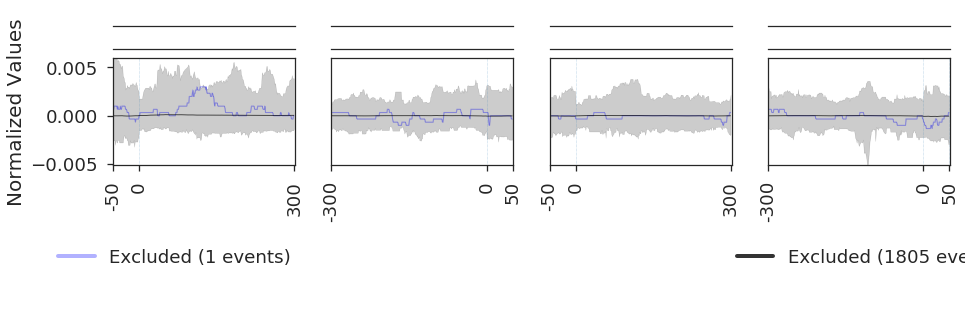

In [14]:
bg._set_std_error_boundaries(bottom_values, top_values)
Plotter.plot_se(lines=[excluded, bg], output_filename=None, map_type=None)

# Check the random sampling of the peak maps
- I will try and re-construct the random sample means to make sure they're being reported properly and not screwed up somewhere along the intermediate steps.

In [128]:
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 1500)
pd.set_option('display.width', 1000)

# I'm printing out individual indices from the 'random sampling' of the 204_01 RBFOX2 RBP. 
# 138 # rand_sample_1_indices = [1546, 1212, 483, 1436, 1254, 1047, 1676, 1108, 1458, 1219, 1203, 1086, 409, 1714, 37, 678, 1616, 42, 164, 1091, 1383, 403, 283, 691, 1378, 1148, 1678, 995, 450, 532, 486, 607, 435, 1661, 666, 1021, 1693, 698, 1423, 1391, 492, 921, 356, 375, 864, 729, 580, 558, 202, 371, 239, 1042, 163, 1052, 1331, 152, 1201, 1049, 1118, 1295, 1473, 1061, 1434, 1017, 1339, 340, 805, 1232, 718, 429, 761, 1493, 1015, 1197, 1339, 1060, 921, 238, 362, 641, 1004, 936, 607, 279, 1683, 1800, 1158, 197, 1066, 1193, 418, 143, 150, 1667, 474, 1611, 1658, 1370, 740, 1322, 377, 1126, 635, 18, 1401, 1669, 1377, 447, 1311, 504, 885, 1758, 509, 641, 308, 844, 310, 815, 954, 1419, 1596, 156, 744, 301, 1261, 260, 1740, 391, 1650, 498, 51, 1387, 1074, 1192, 803, 431, 674, 373]
# 138 # rand_sample_2_indices = [1661, 1800, 441, 1702, 1756, 29, 655, 842, 481, 1550, 1517, 421, 1393, 1613, 886, 697, 1797, 1354, 273, 1387, 169, 487, 808, 814, 1680, 1646, 367, 1517, 1715, 1771, 1494, 1510, 803, 568, 500, 822, 38, 595, 831, 1214, 254, 889, 903, 239, 376, 1652, 1184, 775, 1719, 127, 1399, 889, 1536, 627, 1507, 700, 547, 1019, 147, 926, 167, 1164, 726, 35, 1617, 954, 254, 1733, 666, 533, 1621, 1390, 529, 541, 966, 453, 48, 1234, 852, 1033, 1636, 418, 344, 1459, 588, 921, 1104, 610, 1537, 783, 143, 557, 1370, 772, 599, 738, 573, 67, 1280, 1396, 1502, 585, 127, 1106, 1751, 464, 471, 1412, 1691, 1372, 683, 135, 525, 187, 1668, 418, 869, 314, 1114, 587, 321, 1189, 693, 562, 372, 456, 1750, 806, 1346, 27, 220, 631, 1184, 918, 1293, 1501, 1668, 131]

# 113 
rand_sample_0_indices = [1172, 435, 944, 263, 182, 1304, 674, 1647, 599, 386, 1442, 1092, 1588, 1034, 82, 1436, 555, 237, 412, 1134, 566, 383, 1214, 1035, 1444, 109, 853, 96, 1002, 1187, 1500, 597, 1108, 183, 1013, 1169, 306, 1352, 1741, 656, 1002, 892, 1143, 394, 398, 1333, 1586, 30, 1331, 758, 1057, 1241, 1510, 1435, 263, 293, 1390, 578, 1053, 697, 961, 1138, 1704, 208, 1100, 1544, 574, 336, 1582, 898, 1434, 64, 472, 1030, 1345, 1785, 1566, 1180, 658, 891, 196, 927, 630, 15, 1554, 363, 1616, 127, 1226, 581, 1496, 39, 739, 1626, 199, 303, 58, 929, 1098, 401, 531, 791, 1198, 1362, 631, 1746, 1075, 863, 499, 1688, 296, 1580, 628]
rand_sample_6_indices = [196, 559, 213, 1634, 300, 1073, 1584, 1559, 1276, 71, 1584, 164, 323, 1782, 1498, 1648, 1666, 514, 286, 1550, 1305, 932, 1151, 1236, 458, 1688, 675, 689, 1179, 160, 419, 1744, 1270, 976, 922, 1770, 578, 237, 569, 1282, 567, 1661, 576, 1066, 1535, 1194, 656, 1609, 184, 456, 1764, 1588, 584, 984, 520, 1775, 990, 1330, 110, 1335, 94, 1386, 1509, 47, 881, 1163, 825, 938, 1554, 554, 1548, 683, 1370, 621, 260, 1759, 1554, 714, 1311, 1214, 109, 1791, 851, 518, 461, 29, 462, 131, 1279, 1184, 1063, 212, 1595, 645, 1113, 281, 1143, 674, 86, 584, 677, 10, 1329, 783, 60, 1061, 293, 1112, 1772, 1430, 914, 471, 1189]

In [129]:
# I'm testing against the native exon events (see: /home/bay001/projects/brian_rbpmaps_20180202/permanent_data/maps/adhoc/run_204_01_and_216_01_peak_permutation_maps_small_test.sh)
bg_matrix = pd.read_table(
    '/home/bay001/projects/brian_rbpmaps_20180202/permanent_data/maps/adhoc/maps-test/204_01.basedon_204_01.peaks.l2inputnormnew.bed.compressed.bed.p3f3.bed.sorted.bed.bb.HepG2_native_cassette_exons_all.normed_matrix.txt',
    sep=',',
    index_col=0
)
print(bg_matrix.shape)

(1805, 1400)


In [134]:
# assert that the subset matrix is the same dimensions as the number of "excluded" events.
print(bg_matrix.iloc[rand_sample_6_indices,].shape)
rand_subset = bg_matrix.iloc[rand_sample_6_indices,]

(113, 1400)


In [135]:
from pandas.util.testing import assert_frame_equal

# make sure we're taking the true means for peak-based maps, and not removing outliers
means, _, _, _ = norm.get_means_and_sems(rand_subset, conf=1)
means2 = rand_subset.mean()

assert_frame_equal(pd.DataFrame(sorted(means)), pd.DataFrame(sorted(means2)))

In [136]:
# load the saved TSV file that contains the means for all random sampling iterations. IN this case, I did 10 random permutations.
rand_tsv = pd.read_table(
    '/home/bay001/projects/brian_rbpmaps_20180202/permanent_data/maps/adhoc/maps-test/204_01.basedon_204_01.peaks.l2inputnormnew.bed.compressed.bed.p3f3.bed.sorted.bed.bb.svg.HepG2_native_cassette_exons_all.RBFOX2-BGHLV26-HepG2.set26-included-upon-knockdown.randsample.tsv',
    sep='\t',
    index_col=0
)
rand_tsv

0    1    2    3    4    5    6    7    8    9                10                11                12                13                14                15                16                17                18                19                20                21                22                23                24                25                26                27                28                29                30                31                32                33                34                35                36                37                38                39                40                41                42                43                44                45                46                47                48                49                50                51                52                53                54                55                56                57                58                59                60                61  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00884955752212  0.00884955752212  0.01769911504420  0.01769911504420  0.01769911504420  0.01769911504420  0.01769911504420  0.01769911504420   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.00917431192661  0.00917431192661  0.00917431192661  0.00917431192661  0.00917431192661  0.00909090909091  0.00909090909091  0.00900900900901  0.00900900900901  0.00900900900901  0.00900900900901  0.00892857142857  0.00892857142857  0.00892857142857  0.00892857142857  0.00892857142857  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00000000000000  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.00900900900901  0.00900900900901  0.00900900900901  0.00900900900901  0.00892857142857  0.00892857142857  0.00892857142857  0.00892857142857  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.01769911504420  0.01769911504420  0.01769911504420  0.01769911504420  0.01769911504420  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212  0.00884955752212   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [137]:
# the means and means2 from above should match one of the rows in the rand_test dataframe, since this dataframe contains the mean values for each random permutation iteration.
test_means = pd.DataFrame(means)
for col_to_test in range(10):
    try:
        test_means.columns = [col_to_test]
        rand_test_col = pd.DataFrame(rand_tsv.iloc[col_to_test,])
        rand_test_col.index = range(1400)
        assert_frame_equal(rand_test_col, test_means)
        print(col_to_test)
    except AssertionError as e:
        pass

6
